In [67]:
# let's create a autoencoder model that colors black and white images
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
import cv2
import re
from tqdm import tqdm
import keras
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array


In [ ]:
SIZE = 160 # size of the image (160*160)

def sorted_alphanumeric(data):
    """ 
    This is a function that sorts the files in a foldr in alphanumeric order.
    args:
        data:  list of files(images for our case)
    """ 
    convert = lambda text: int(text) if text.isdigit() else text.lower() # convert to int if possible
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)] # split the text and numbers
    return sorted(data,key = alphanum_key) # sort according to the numbers
# defining the size of the image

In [68]:
color_img = []
path = '/Users/ardacanli/ITU/FALL 23-24/DL/project/images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):    
    if i == '9057.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1) # reading the image
        # converting the image to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = cv2.resize(img, (SIZE, SIZE)) # resizing the image according to our defined size
        img = img.astype('float32') / 255.0 # normalizing the image for the activation function
        color_img.append(img_to_array(img))


# same process for the gray images
gray_img = []
path = '/Users/ardacanli/ITU/FALL 23-24/DL/project/images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):
     if i == '9057.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        gray_img.append(img_to_array(img))

  0%|          | 0/8279 [00:00<?, ?it/s]

100%|██████████| 8279/8279 [00:03<00:00, 2257.10it/s]


In [69]:
# splitting the data into train and test
# ranges are manually selected because we wanted to make sure there are images both from military and landscape images
train_gray_image = gray_img[1400:8000]
train_color_image = color_img[1400:8000]
test_gray_image = gray_img[:1400] + gray_img[8000:]
test_color_image = color_img[:1400] + color_img[8000:]

# reshaping the data for the model
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)
test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (6600, 160, 160, 3)
Test color image shape (1679, 160, 160, 3)


In [70]:
#let's create our model


from keras import layers
def down(filters, size, apply_batch_normalization = True):
    """ 
    This is a function that creates a downsample layer
    args:
        filters: number of filters
        size: size of kernel(kernel is a matrix that is used to extract features from the image)
        apply_batch_normalization: if True, apply batch normalization
    returns:
        result: downsampled layer
        """
    # initilize the weights 
    initializer = tf.random_normal_initializer(0.,0.02) 
    # create a sequential model
    result = keras.Sequential()
    # add a convolutional layer
    result.add(layers.Conv2D(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = not apply_batch_normalization))
    if apply_batch_normalization:
        result.add(layers.BatchNormalization())

    # after the convolutional layer, we add a leaky relu layer
    result.add(layers.LeakyReLU())
    return result

def up(filters, size, dropout = False):
    """ 
    This is a function that creates a upsample layer
    args:
        filters: number of filters
        size: size of kernel(kernel is a matrix that is used to extract features from the image)
        dropout: if True, apply dropout
    returns:
        result: upsampled layer"""
    # same approach as the down function
    initializer = tf.random_normal_initializer(0.,0.02)
    result = keras.Sequential()
    # this time adding a transpose convolutional layer to keep the size of the image same
    result.add(layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same', kernel_initializer = initializer, use_bias = False))
    result.add(layers.BatchNormalization())
    if dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result
def autoencoder():
    """
    This function creates our autoencoder model and defines our architecture
    There are 4 downsample layers and 4 upsample layers
    We use leaky relu for the downsample layers and relu for the upsample layers
    args:
        None
    returns:
        model: autoencoder model
            """
    inputs = layers.Input(shape= [160,160,3]) # initial input since our images are 160*160
    down_1 = down(128,(3,3),apply_batch_normalization = False)(inputs) # no batch normalization for the first layer
    down_2 = down(128,(3,3))(down_1)
    down_3 = down(256,(3,3))(down_2)
    down_4 = down(512,(3,3))(down_3)
    # there is no bottleneck layer in our model since we are not using a fully connected layer
    up_1 = up(512,4)(down_4)
    up_1 = keras.layers.Concatenate()([up_1, down_3])
    up_2 = up(256,4,dropout = True)(up_1) # we apply dropout to the second upsample layer to prevent overfitting and improve generalization
    up_2 = keras.layers.Concatenate()([up_2, down_2])
    up_3 = up(128,4)(up_2)
    up_3 = keras.layers.Concatenate()([up_3, down_1])
    up_4 = up(128,4)(up_3)
    outputs = layers.Conv2D(3, (3,3), activation = 'sigmoid', padding = 'same')(up_4)
    return keras.Model(inputs = inputs, outputs = outputs)


model = autoencoder()
model.compile(optimizer = 'adam', loss = 'mse') # we use mse as our loss function since we are dealing with images
model.summary()





Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential_84 (Sequential)  (None, 80, 80, 128)          3584      ['input_14[0][0]']            
                                                                                                  
 sequential_85 (Sequential)  (None, 40, 40, 128)          147968    ['sequential_84[0][0]']       
                                                                                                  
 sequential_86 (Sequential)  (None, 20, 20, 256)          295936    ['sequential_85[0][0]']       
                                                                                           

In [71]:
# let's train our model
# we will use early stopping to prevent overfitting and reduce training time
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)
history = model.fit(train_g, train_c, epochs = 20, batch_size = 32, validation_split = 0.1, callbacks = [early_stopping])


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 sequential_92 (Sequential)  (None, 80, 80, 128)          3584      ['input_15[0][0]']            
                                                                                                  
 sequential_93 (Sequential)  (None, 40, 40, 128)          147968    ['sequential_92[0][0]']       
                                                                                                  
 sequential_94 (Sequential)  (None, 20, 20, 256)          295936    ['sequential_93[0][0]']       
                                                                                           

### Let's plot some results

In [72]:
# after training, let's see how our model performs on the test set
predicted_images = model.predict(test_gray_image)

53/53 [==============================] - 78s 1s/step


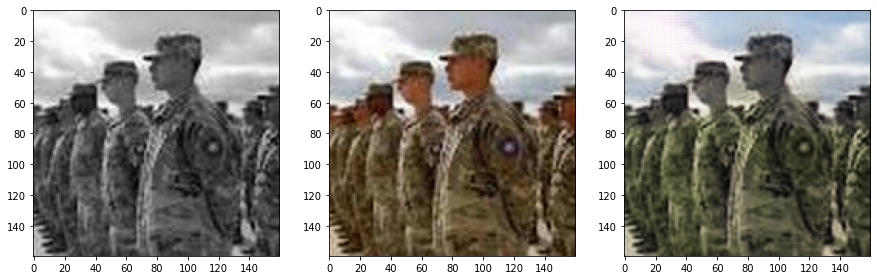

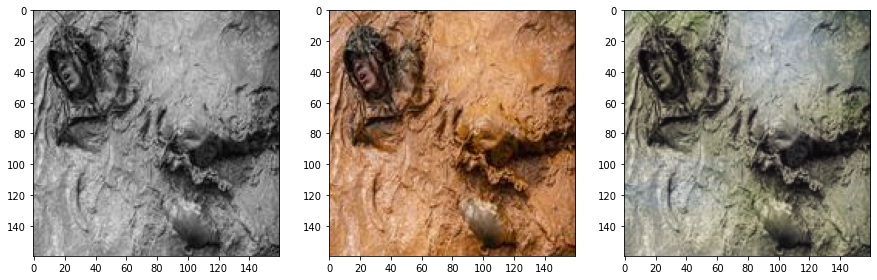

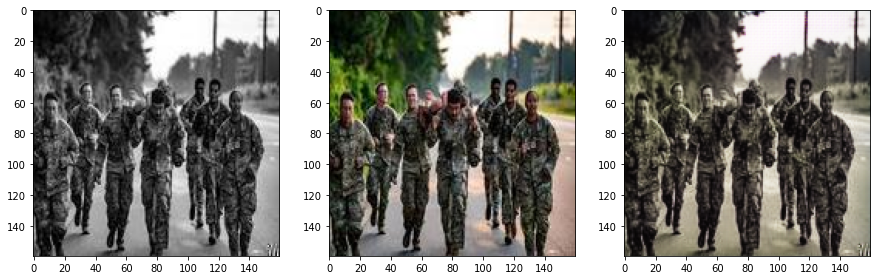

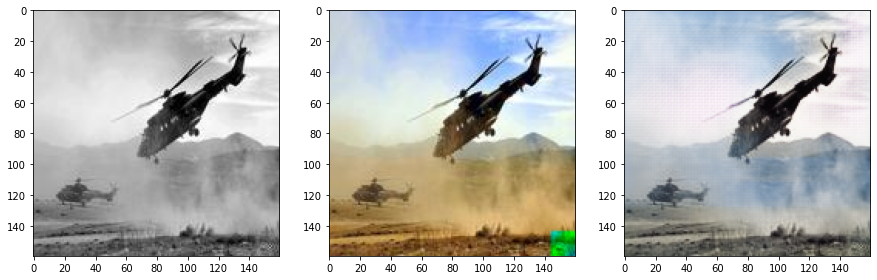

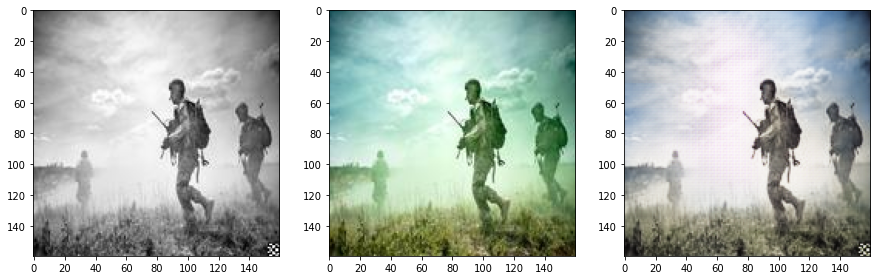

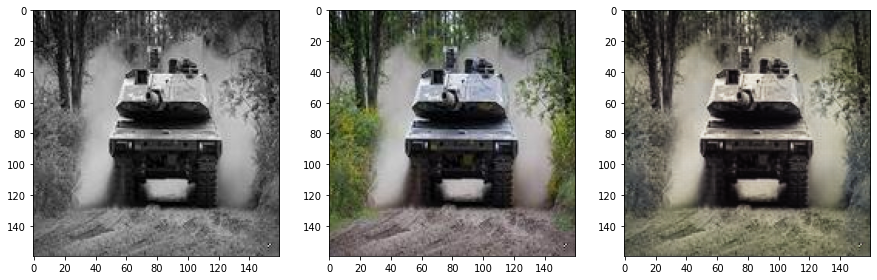

In [122]:
def plot_images(gray_images, color_images, predicted_images, num_images = 5, indexing = -1):
    """ 
    This is helper function that plots the gray image, color image and the predicted image side by side
    args:
        gray_images: list of gray images
        color_images: list of color images
        predicted_images: list of predicted images
        num_images: number of images to plot
        indexing: if -1, plot the last images, if 1 or any other number, plot the first images"""
    if indexing == -1:
        for i in range(num_images):
            fig, axes = plt.subplots(1,3, figsize = (15,10))
        # using negative indexing to plot the last images (since the last ones are about military)
            axes[0].imshow(gray_images[-i])
            axes[1].imshow(color_images[-i])
            axes[2].imshow(predicted_images[-i])
            plt.show()
    else:
        for i in range(num_images):
            fig, axes = plt.subplots(1,3, figsize = (15,10))
            axes[0].imshow(gray_images[i])
            axes[1].imshow(color_images[i])
            axes[2].imshow(predicted_images[i])
            plt.show()

def plot_random_images(gray_images, color_images, predicted_images, num_images = 5):
    """ 
    This is helper function that plots randomly selected images from the test set
    args:
        gray_images: list of gray images
        color_images: list of color images
        predicted_images: list of predicted images
        num_images: number of images to plot"""
    for i in range(num_images):
        fig, axes = plt.subplots(1,3, figsize = (15,10))
        j = random.randint(0,len(gray_images))
        axes[0].imshow(gray_images[j])
        axes[1].imshow(color_images[j])
        axes[2].imshow(predicted_images[j])
        plt.show()

plot_images(test_gray_image, test_color_image, predicted_images, num_images=6, indexing = -1)

### Now let's plot some randomly selected images from our set

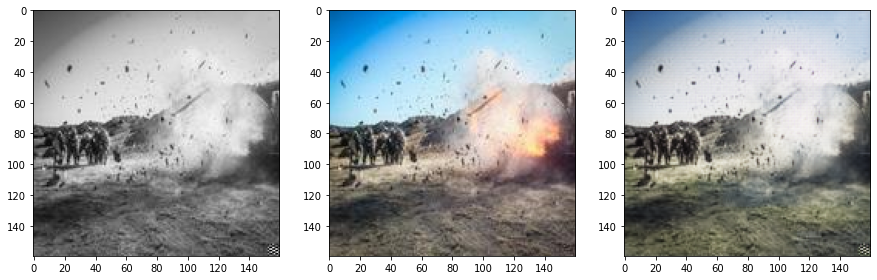

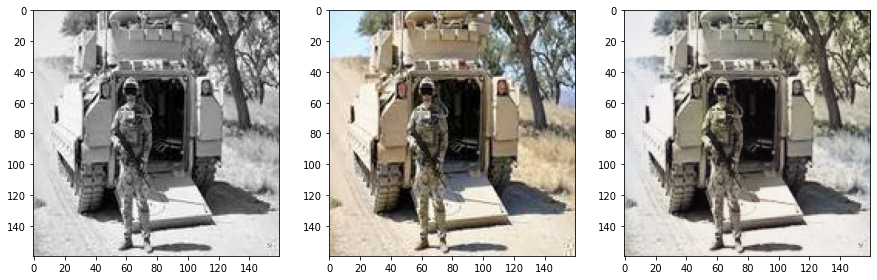

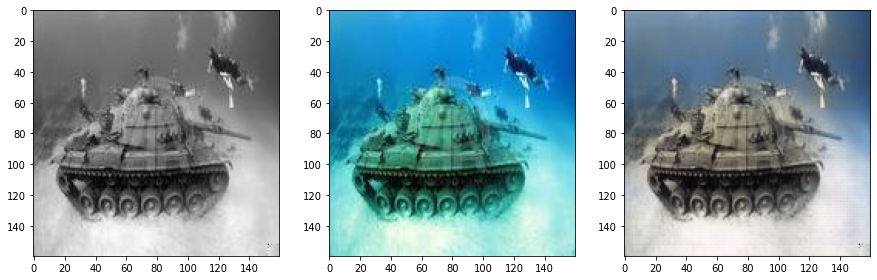

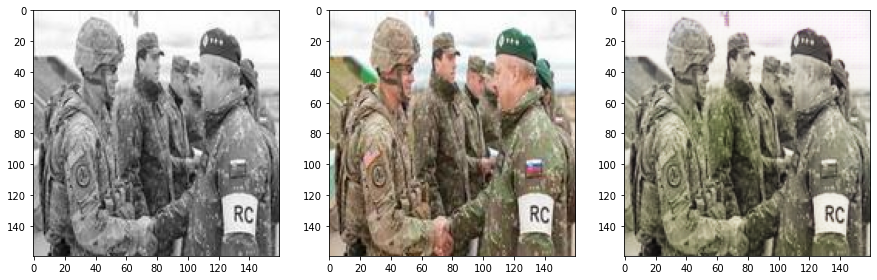

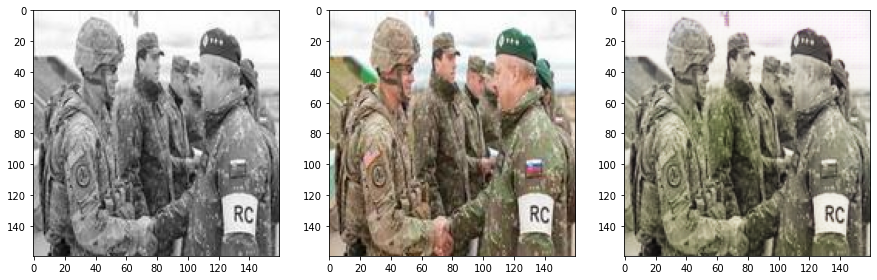

In [136]:
plot_random_images(test_gray_image, test_color_image, predicted_images, num_images=5)


7/7 [==============================] - 10s 1s/step


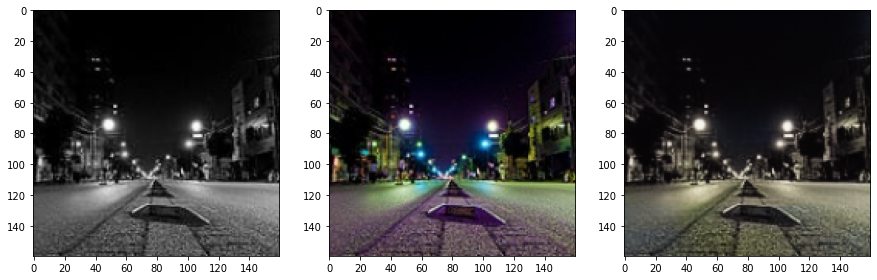

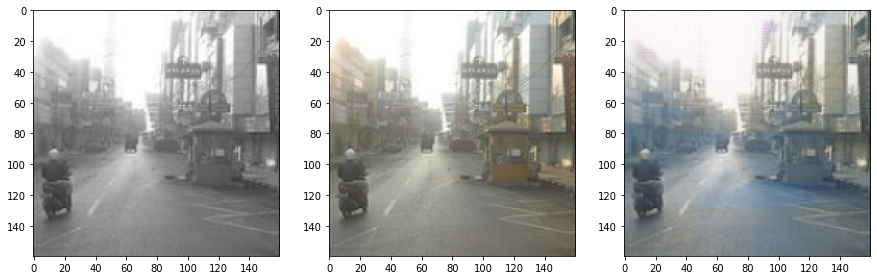

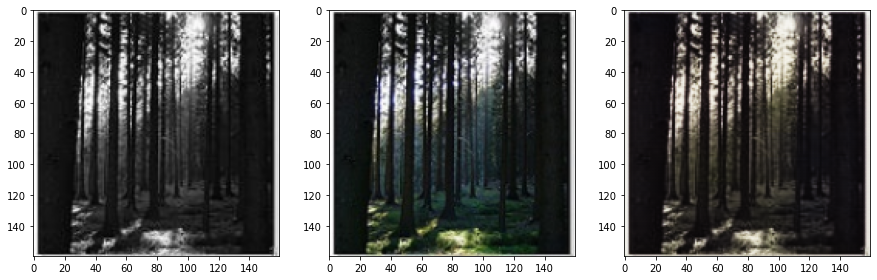

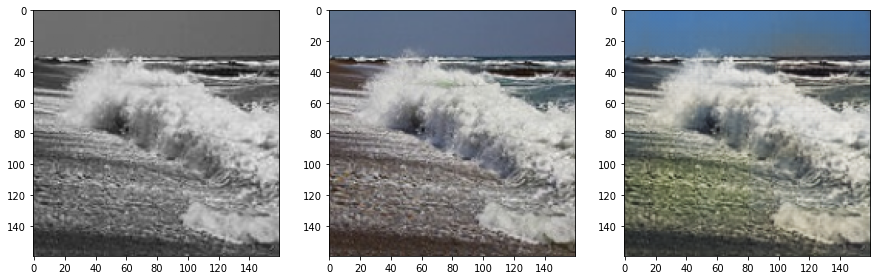

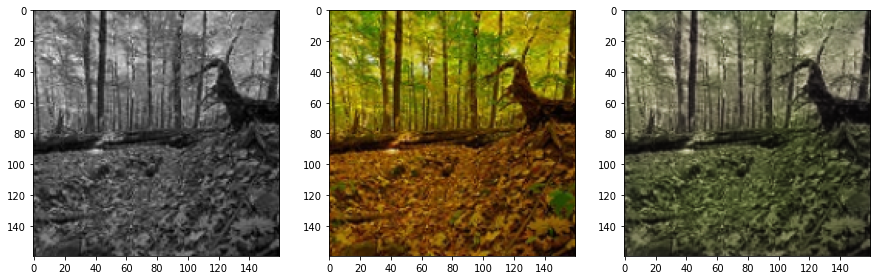

In [151]:
# this cell is for plotting only landscape images 
# now let's see how our model performs on landscape images

# since we know there is only landscape images between 1400 and 1600, we will use that range
test_gray_image = gray_img[1400:1600]
test_color_image = color_img[1400:1600]
test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
predicted_images = model.predict(test_gray_image)
plot_random_images(test_gray_image, test_color_image, predicted_images, num_images=5)

    

Test color image shape (200, 160, 160, 3)
7/7 [==============================] - 10s 1s/step


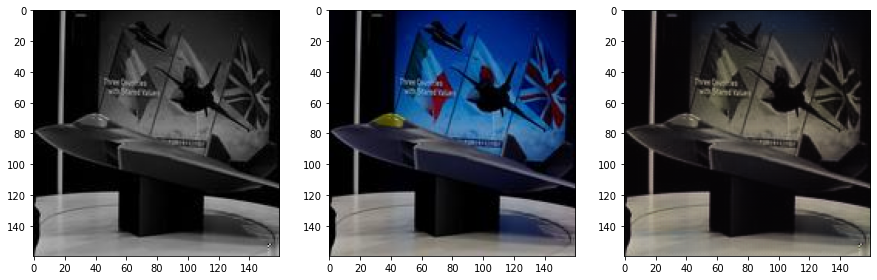

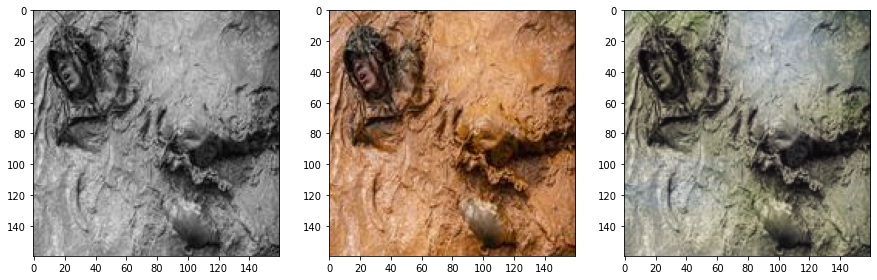

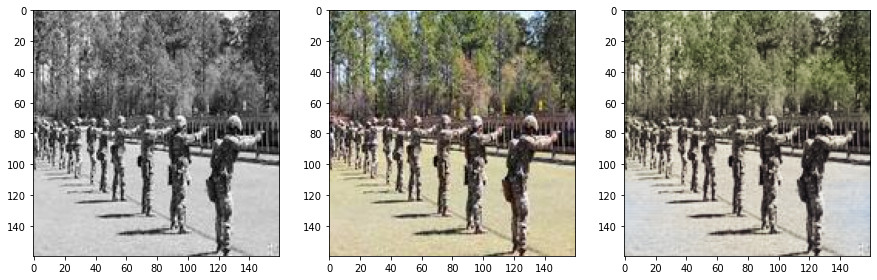

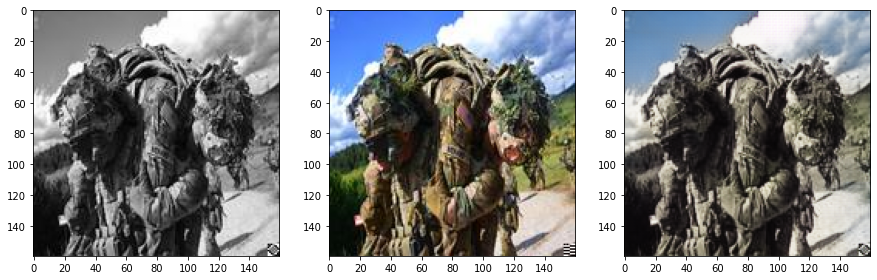

In [153]:
# this is for plotting only military images since we know after 7000, there are only military images

test_gray_image = gray_img[7000:7200] 
test_color_image = color_img[7000:7200]
# reshaping
test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape) # just checking the shape
predicted_images = model.predict(test_gray_image) # make the model predict and plot the results
plot_random_images(test_gray_image, test_color_image, predicted_images, num_images = 4)



1.jpeg
1.jpeg
1/1 [==============================] - 1s 616ms/step


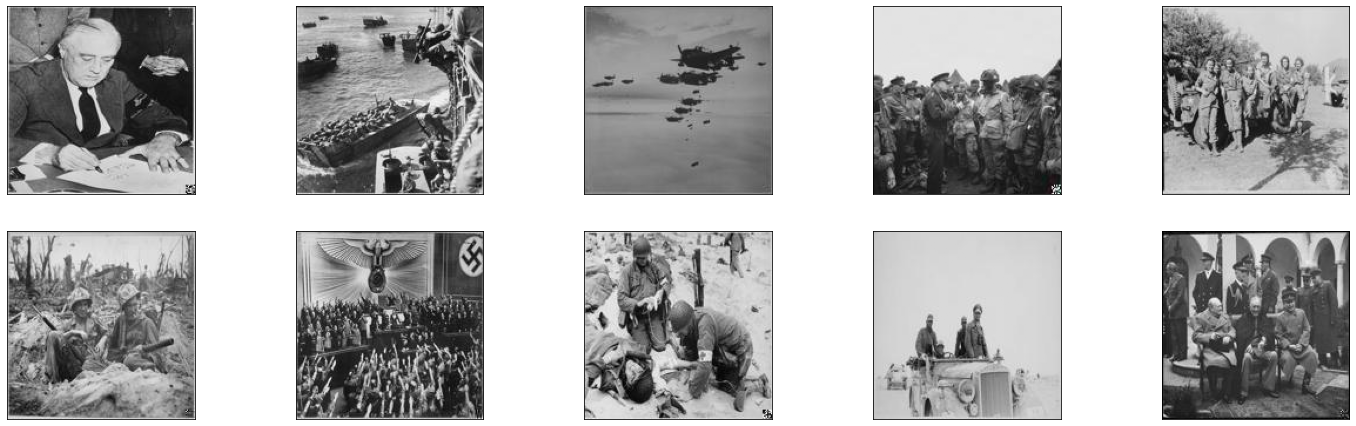

In [159]:
# let's predict some unseen images that have been taken from ww2
path = '/Users/ardacanli/ITU/FALL 23-24/DL/project/images/ww2'
# first let's resize the images to 160x160 since our model only uses that size
from PIL import Image
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in files:
    try:
        # open the image and resize it
        img = Image.open(path + '/' + i)
        img = img.resize((160,160))
        img.save(path + '/' + i)
    except:
        print(i) # if there is any problematic image, print it and continue
        continue

# now let's predict the images
ww2 = []
for i in files:
    try:
        img = cv2.imread(path + '/' + i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        ww2.append(img_to_array(img))
    except:
        print(i) 
        continue

ww2 = np.reshape(ww2,(len(ww2),SIZE,SIZE,3))
predicted_images = model.predict(ww2)
#let's plot some images

fig = plt.figure(figsize = (25,20))
for i in range(10):
    ax = fig.add_subplot(5,5,i+1)
    ax.imshow(ww2[i])
    plt.xticks([])
    plt.yticks([])
plt.show()










predicted ones


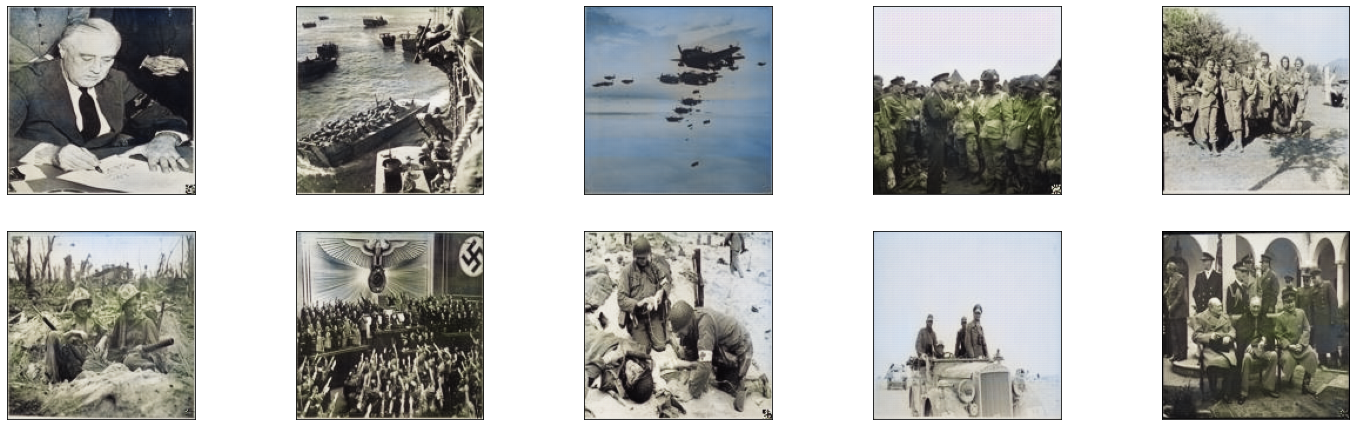

In [164]:
print("predicted ones")
# let's do the same for the predicted images
fig = plt.figure(figsize = (25,20))
for i in range(10):
    ax = fig.add_subplot(5,5,i+1)
    ax.imshow(predicted_images[i])
    plt.xticks([])
    plt.yticks([])
plt.show()


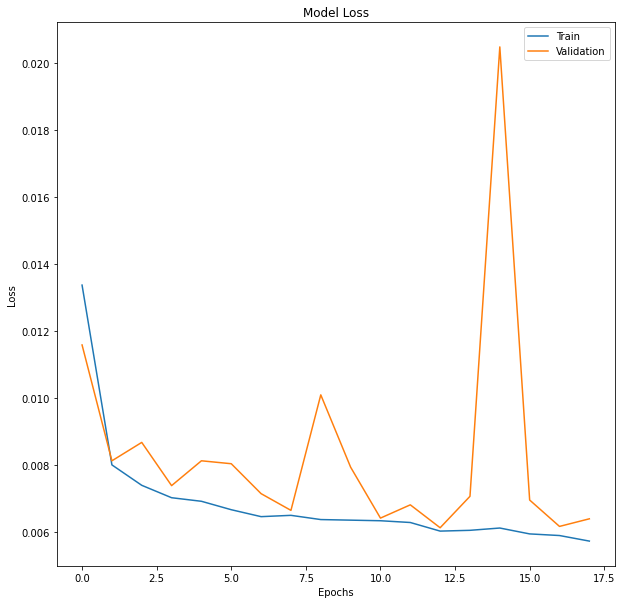

In [165]:
# lastly let's plot the loss and validation loss
fig = plt.figure(figsize = (10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [166]:
# let's save our model for future use
model.save('autoencoder.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(
